### We can construct a mosaic of nearby tiles using this method: https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/discussion/36738

# Import Necessary Libraries

In [1]:
import numpy as np
import os
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras as K
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Input, Dense, Activation, BatchNormalization, Flatten
from tensorflow.keras.models import Sequential, Model

# Preprocess data
---

### Obtain Labels

In [3]:
train_data = pd.read_csv('data/train_v2.csv')

curr_count = 0
unique_labels = {}
for line in train_data['tags'].values:
    for label in line.split():
        if label not in unique_labels:
            unique_labels[label] = curr_count
            curr_count += 1

label2name = {v: k for k, v in unique_labels.items()}

print(label2name)

{0: 'haze', 1: 'primary', 2: 'agriculture', 3: 'clear', 4: 'water', 5: 'habitation', 6: 'road', 7: 'cultivation', 8: 'slash_burn', 9: 'cloudy', 10: 'partly_cloudy', 11: 'conventional_mine', 12: 'bare_ground', 13: 'artisinal_mine', 14: 'blooming', 15: 'selective_logging', 16: 'blow_down'}


# View Head of dataset

In [4]:
train_data.head(n = 10)

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
5,train_5,haze primary water
6,train_6,agriculture clear cultivation primary water
7,train_7,haze primary
8,train_8,agriculture clear cultivation primary
9,train_9,agriculture clear cultivation primary road


In [5]:
# first pass, construct a list of image strips

train_path = 'data/train-jpg/'

num_images = len(os.listdir(train_path))

X = []
y = []

num_jpgs = 2500
for iter, file in enumerate(os.listdir(train_path)[:num_jpgs]):
    # load image as numpy array
    image = matplotlib.image.imread(train_path + file).astype(int)

    # drop alpha channel
    image = image[:, :, :3]

    # append to list containing 4-tuples of image strips: (left, right, top, bottom)
    X.append( image )
    y.append(train_data['tags'][iter])

    if iter % (0.05 * num_jpgs) == 0:
        print(f"{(100 * iter / num_jpgs):.2f} % complete")

0.00 % complete
5.00 % complete
10.00 % complete
15.00 % complete
20.00 % complete
25.00 % complete
30.00 % complete
35.00 % complete
40.00 % complete
45.00 % complete
50.00 % complete
55.00 % complete
60.00 % complete
65.00 % complete
70.00 % complete
75.00 % complete
80.00 % complete
85.00 % complete
90.00 % complete
95.00 % complete


In [29]:
train_data.iloc[1]['tags'].replace(' ', ', ')

'agriculture, clear, primary, water'

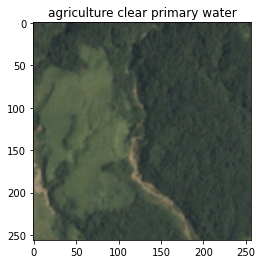

In [24]:
def show_image(idx, X):
    img = X[idx]
    plt.imshow(img)
    plt.title(train_data.iloc[idx]['tags'].split('').join(', '))
    plt.show()

show_image(1, X)

# Construct model
---

In [ ]:
initializer = K.initializers.HeNormal()

res = (256, 256)
batch_size = 32
epochs = 10

datagen = K.preprocessing.image.ImageDataGenerator(
                                          rotation_range=40,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          shear_range=0.2,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          validation_split = .2,
                                          fill_mode='nearest')
train_gen = datagen.flow(X,
                             y,
                             subset = 'training',
                             batch_size=32)

val_gen = datagen.flow(X,
                            y,
                            subset = 'validation',
                            batch_size=32)

ds_model = Sequential()
ds_model.add(K.layers.Lambda(lambda image: tf.image.resize(image, res)))
ds_model.add(GlobalAveragePooling2D())
ds_model.add(BatchNormalization())

ds_model.add(Conv2D(256, kernel_initializer=initializer, kernel_regularizer='l1'))
ds_model.add(BatchNormalization())
ds_model.add(K.layers.Activation('relu'))

ds_model.add(Conv2D(128,kernel_initializer=initializer, kernel_regularizer='l1'))
ds_model.add(BatchNormalization())
ds_model.add(K.layers.Activation('relu'))

ds_model.add(Conv2D(10, activation = 'softmax'))

ds_model.compile(loss='sparse_categorical_crossentropy', optimizer=K.optimizers.SGD(learning_rate=6e-3, momentum = .9),
              metrics=['accuracy'])
ds_history = ds_model.fit(train_gen, epochs = epochs, batch_size = batch_size, validation_data = val_gen, verbose = 1)
# base_model.summary()

# Train model
---

# View results
---